In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 23c: 

## MNIST feminist Data


<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
# Lets import some libraries
import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf

%matplotlib inline

2023-12-05 10:45:41.939355: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-05 10:45:41.942133: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-05 10:45:41.979121: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 10:45:41.979152: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 10:45:41.979173: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
# Strictly for tensorflow version 2.12
### To hide bugs throwing warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [5]:
# Some basic parameters

inpDir = '/home/dai/6. DNN/CNN/Flower' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir='../model'
subDir='flower_photos'
altName = 'Grp_2_project'



RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results

EPOCHS = 50  # number of cycles to run

ALPHA = 0.001  # learning rate

TEST_SIZE = 0.2 # What fraction we want to keep for testing

BATCH_SIZE = 32

FACTOR_LR = 0.5

LR_PATIENCE = 2

PATIENCE = 10
IMG_HEIGHT = 190
IMG_WIDTH = 190


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (12,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }
CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

## Helper Function

In [6]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def plot_tf_hist(hist_df):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [7]:
def fn_plot_label(tr_ds, ts_ds):
    
    
    plt.figure(figsize = (15,5))  # instantiate the figure
    
    # -----------------------------------------------------------------------------------------
    
    # labels for the training set
    
    plt.subplot(1,2,1) # first of the 2
    
    train_labels = tf.concat([lbl for img, lbl in tr_ds], axis = 0).numpy() # get the labels
    
    unique, _, counts = tf.unique_with_counts(train_labels) # get counts
    
    plt.bar(range(len(unique)), counts, align='center', color = 'DarkBlue') # barplot the counts
    
    plt.xticks(range(len(unique)), class_names)
    
    plt.title('Training set')
    

    # -----------------------------------------------------------------------------------------
    
    # labels for the testing set
    
    plt.subplot(1,2,2)
    
    test_labels = tf.concat([lbl for img, lbl in ts_ds], axis = 0).numpy()
    
    unique_tst, _, counts = tf.unique_with_counts(test_labels)
    
    plt.bar(range(len(unique_tst)), counts, align='center', color = 'Orange')
    
    plt.xticks(range(len(unique)), class_names)
    
    plt.title('Testing set')
    

###  Using Flower dataset

## Converting to Datsets  from a directory

In [8]:
data_dir = os.path.join(inpDir,subDir)
data_dir

'/home/dai/6. DNN/CNN/Flower/flower_photos'

In [9]:
os.listdir(data_dir)

['sunflowers', 'tulips', 'dandelion', 'roses', 'daisy']

In [10]:
# Creating training data

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,  # path to the data directory
    validation_split=TEST_SIZE, # What is the ratio of validation data
    subset='training', #purpose
    seed=RANDOM_STATE,
    image_size=[IMG_HEIGHT, IMG_WIDTH], # images of all the sizes will be squeezed to 150 x 150 image size
    batch_size= BATCH_SIZE
)

# test data

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,  # path to the data directory
    validation_split=TEST_SIZE, # What is the ratio of validation data
    subset='validation', #purpose
    seed=RANDOM_STATE,
    image_size=[IMG_HEIGHT, IMG_WIDTH], # images of all the sizes will be squeezed to 150 x 150 image size
    batch_size= BATCH_SIZE
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [11]:
# is it picking class names
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

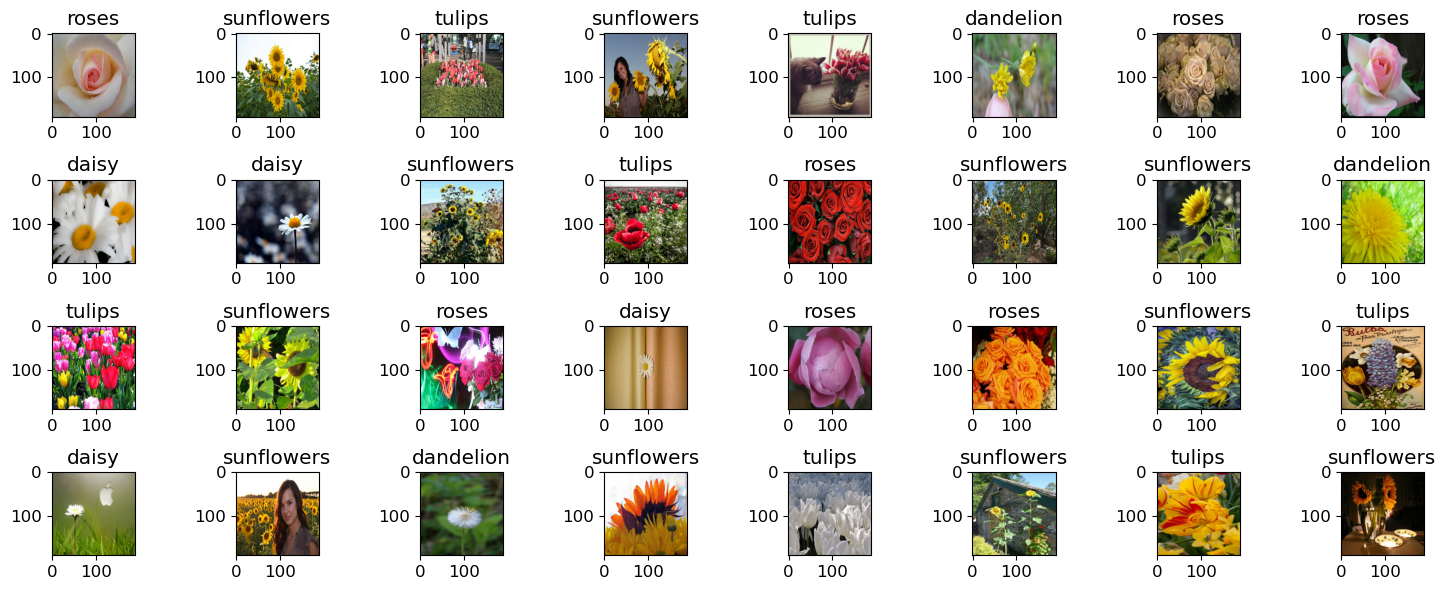

In [12]:
plt.figure(figsize=(15,6))

for images, lables in train_ds.take(1):  # taking one batch from the dataset
    
    for i in range(BATCH_SIZE): # looping over one batch
        
        row = 4
        
        plt.subplot(row, BATCH_SIZE // 4, i+1) # Access the axis
        
        plt.grid(False)  # no grid
        
        plt.imshow(images[i].numpy().astype('uint8'))  # Show image, (convert to numpy and int)
        
        plt.title(class_names[lables[i]])

    plt.tight_layout()

plt.show()

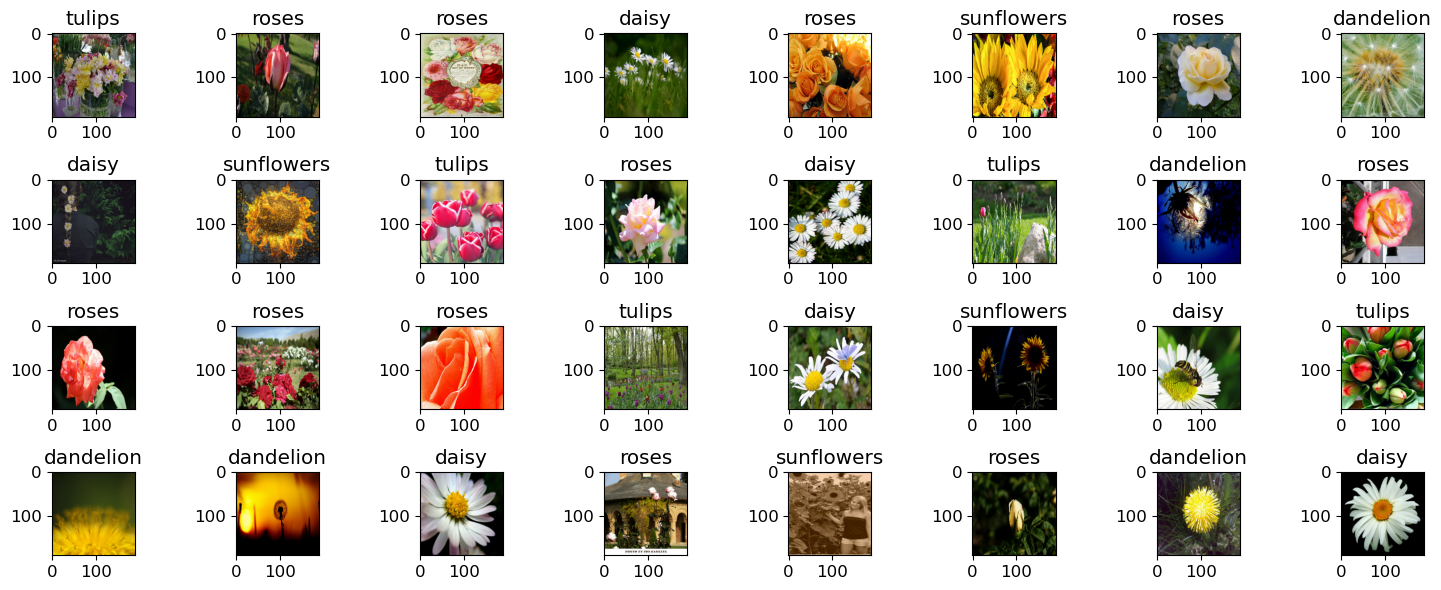

In [13]:
plt.figure(figsize=(15,6))

for images, lables in test_ds.take(1):  # taking one batch from the dataset
    
    for i in range(BATCH_SIZE): # looping over one batch
        
        row = 4
        
        plt.subplot(row, BATCH_SIZE // 4, i+1) # Access the axis
        
        plt.grid(False)  # no grid
        
        plt.imshow(images[i].numpy().astype('uint8'))  # Show image, (convert to numpy and int)
        
        plt.title(class_names[lables[i]])

    plt.tight_layout()

plt.show()

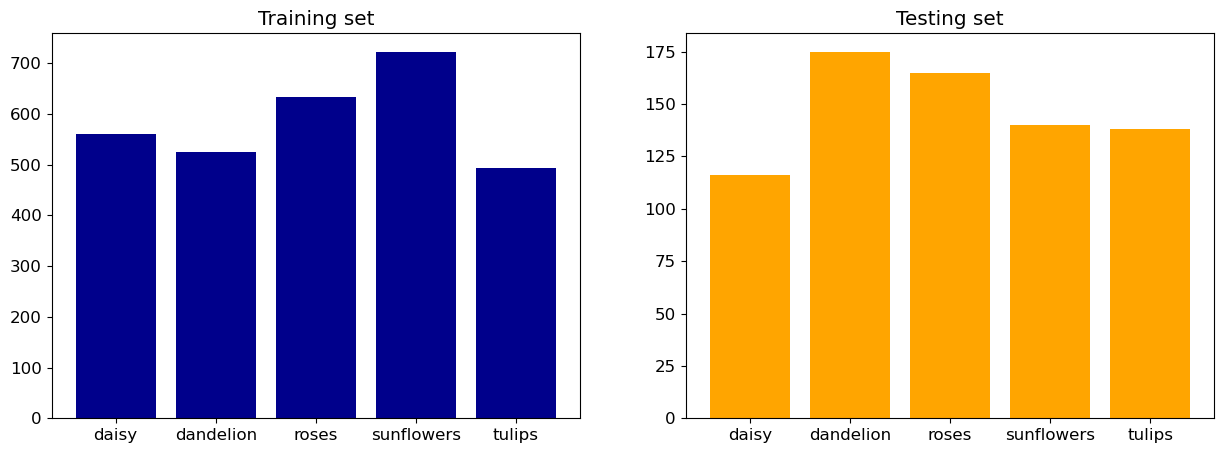

In [14]:
fn_plot_label(train_ds, test_ds)

In [15]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

##  Random Zoom

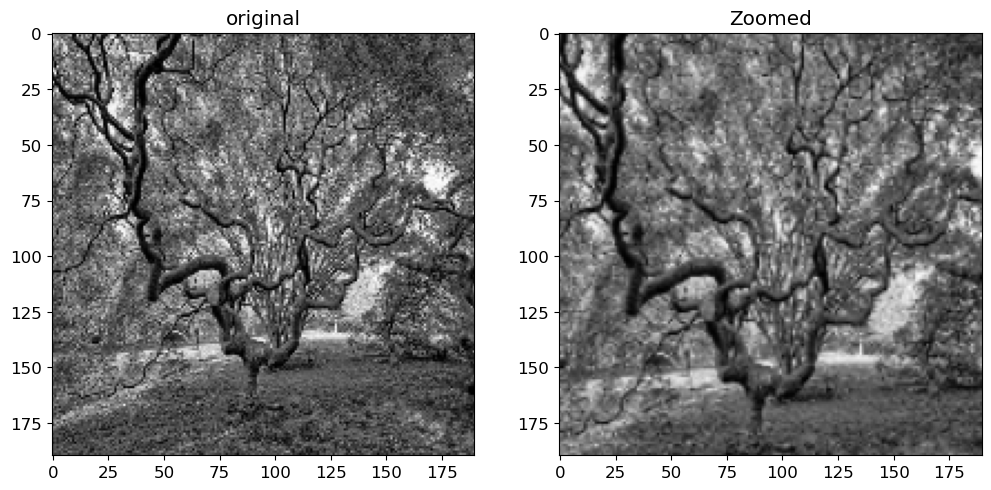

In [16]:
# method in tensorflow to randomly zoom 

layer = tf.keras.layers.RandomZoom(height_factor = (-0.2, -0.2), # range for the zooming (given in the form of tuple)
                                   width_factor = (-0.2, -0.2)
                                  )

plt.figure()

img_num = 3

for image, label in test_ds.take(1): # get one batch
    
    out_img = layer(image)
    
    plt.subplot(1,2,1)
    
    plt.title('original')
    
    plt.imshow(image[img_num].numpy().astype('uint8'))
    
    
    plt.subplot(1,2,2)
    
    plt.title('Zoomed')
    
    plt.imshow(out_img[img_num].numpy().astype('uint8'))

##  Random Rotation

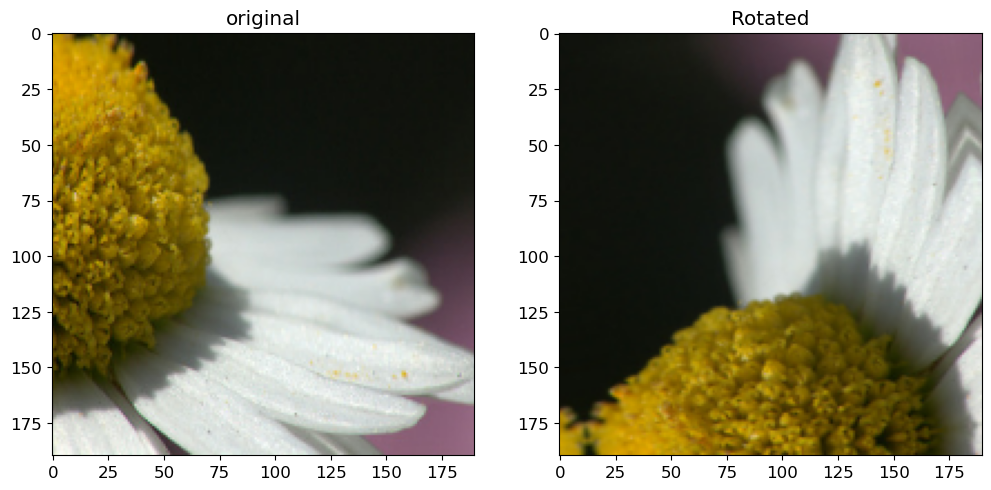

In [17]:
# applying method to radomly rotate a image

layer = tf.keras.layers.RandomRotation(factor = (-0.2, 0.3),
                                       fill_mode='reflect', #The input is extended by reflecting about the edge of the last pixel.
                                       interpolation='bilinear'
                                      )

plt.figure()

img_num = 3

for image, label in test_ds.take(1): # get one batch
    
    out_img = layer(image)
    
    plt.subplot(1,2,1)
    
    plt.title('original')
    
    plt.imshow(image[img_num].numpy().astype('uint8'))
    
    
    plt.subplot(1,2,2)
    
    plt.title('Rotated')
    
    plt.imshow(out_img[img_num].numpy().astype('uint8'))

In [18]:
train_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [19]:
# Build model

model = tf.keras.Sequential()

model.add(tf.keras.layers.Rescaling(1/255.)) # convert between 0 and 1


### ------
### Set 1
### ------

model.add(tf.keras.layers.Conv2D(8, (3,3),
                                activation='relu')) # 188 X 188 X 8

model.add(tf.keras.layers.MaxPool2D(2,2)) # 94 X 94 X 8



### ------
### Set 2
### ------

model.add(tf.keras.layers.Conv2D(16, (3,3),
                                activation='relu')) # 92 X 92 X 16

model.add(tf.keras.layers.MaxPool2D(2,2)) # 46 X 46 X 16



### ------
### Set 3
### ------

model.add(tf.keras.layers.Conv2D(32, (3,3),
                                activation='relu')) # 44 X 44 X 632

model.add(tf.keras.layers.MaxPool2D(2,2)) # 22 X 22 X 32



### ------
### Set 4
### ------

model.add(tf.keras.layers.Conv2D(64, (3,3),
                                activation='relu')) # 20 X 20 X 64

model.add(tf.keras.layers.MaxPool2D(2,2)) # 10 X 10 X 64



### ------
### Set 5
### ------

model.add(tf.keras.layers.Conv2D(128, (3,3),
                                activation='relu')) # 8 X 8 X 128

model.add(tf.keras.layers.MaxPool2D(2,2)) # 4 X 4 X 128




model.add(tf.keras.layers.Conv2D(256, (3,3),
                                activation='relu')) # 2 X 2 X 128

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation=''))


In [20]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optim = tf.keras.optimizers.Adam(learning_rate=ALPHA)

model.compile(optimizer=optim, loss=loss_fn, metrics=['accuracy'])

In [21]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

###  Checkpoint

In [ ]:
filepath=os.path.join(inpDir,subDir, altName)

In [ ]:
# Early stopping callback

es_check_point=tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    min_delta=0,
    patience=PATIENCE,
    verbose=1,
    restore_best_weights=True,
    start_from_epoch=False,
)

''' 
    
    When the loss stops decreasin for cycles = parience level, at that time we will reduce the alpha level.
    this is acieved by the ReduceLROnPlateau
    
'''

# Learning rate decay callback

lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=FACTOR_LR,
    patience=LR_PATIENCE,
    verbose=1,
    mode='auto'
)

model_check_point=tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor = 'val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode = 'auto',
)

In [ ]:
history = model.fit(train_ds,
                    validation_data=test_ds,
                    batch_size=BATCH_SIZE,
                    epochs=50,
                    verbose=1,
                    callbacks=[es_check_point, lr, model_check_point]
                   )

In [ ]:
d4tg=po

In [ ]:
es_check_point=tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience=PATIENCE,
    verbose=1,
    restore_best_weights=True,
    start_from_epoch=False,
)

''' 
    
    When the loss stops decreasin for cycles = parience level, at that time we will reduce the alpha level.
    this is acieved by the ReduceLROnPlateau
    
'''



lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=FACTOR_LR,
    patience=LR_PATIENCE,
    verbose=1,
    mode='auto'
)


In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate = ALPHA)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optim, 
             loss=loss_fn,
             metrics=['accuracy'])

In [ ]:
history=model.fit(train_ds,
                  validation_data=test_ds,
                  epochs=EPOCHS,
                  verbose=1,
                  batch_size=BATCH_SIZE,
                  callbacks=[es_check_point,lr]
                 )

In [ ]:
res_df = pd.DataFrame(history.history)

plot_tf_hist(res_df)